In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 16*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

4867


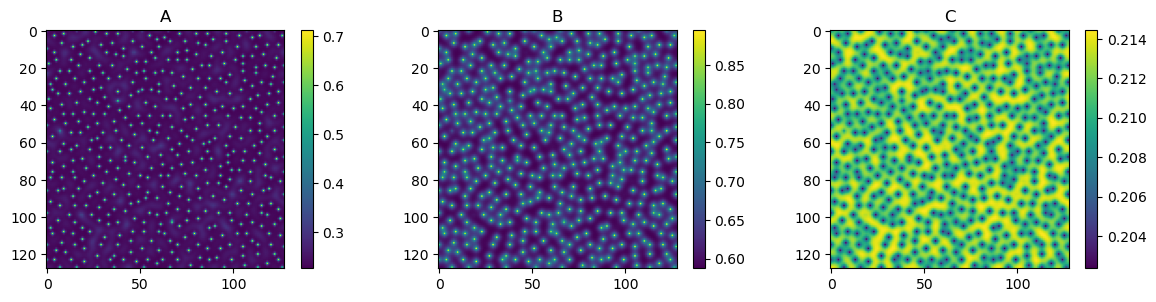

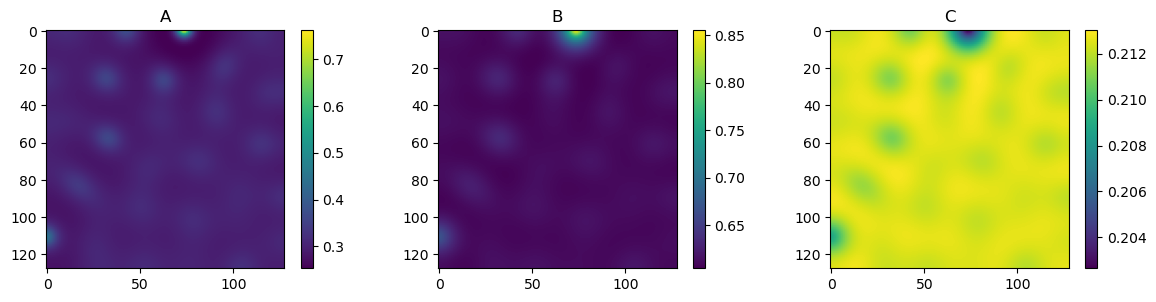

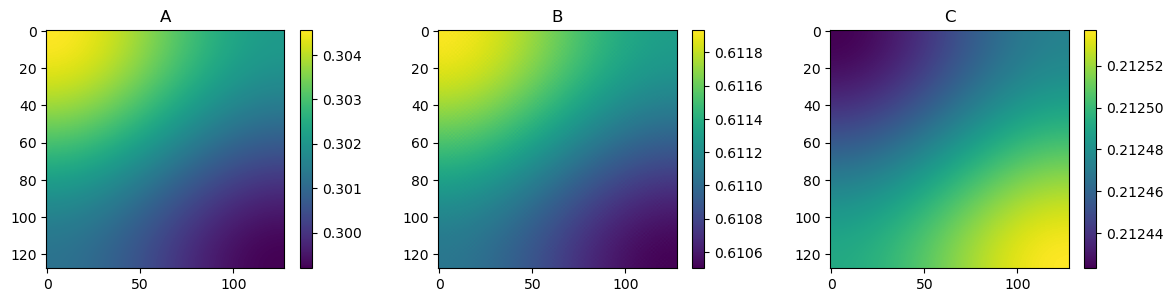

In [5]:
index = 10#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=50
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

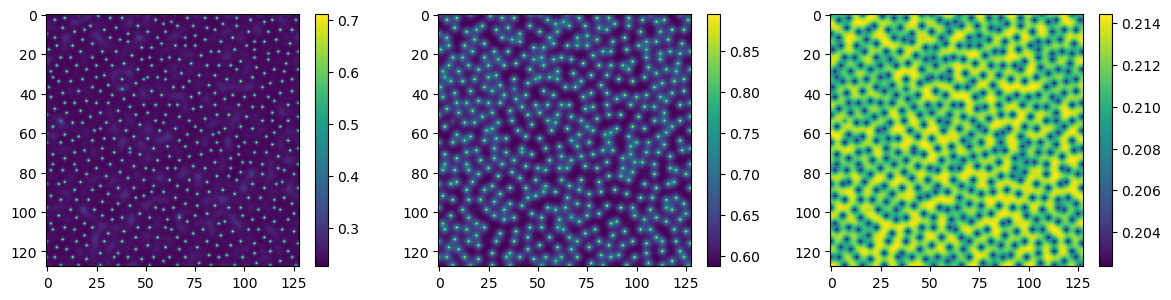

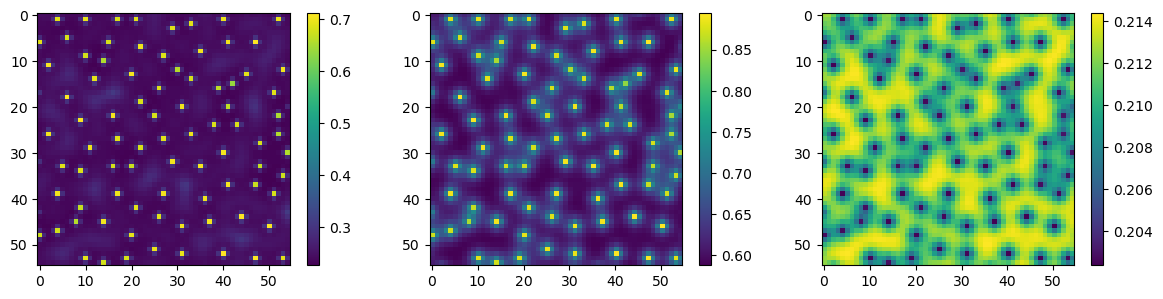

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [8]:
print(np.min(data[0, x_slice, y_slice, -1]), np.max(data[0, x_slice, y_slice, -1]))
print(np.min(data[1, x_slice, y_slice, -1]), np.max(data[1, x_slice, y_slice, -1]))
print(np.min(data[2, x_slice, y_slice, -1]), np.max(data[2, x_slice, y_slice, -1]))

0.22657609402670892 0.7120346928493714
0.5879678944135944 0.8945781714740226
0.20236859263849427 0.21440054876246586


In [9]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [10]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 4*1024, 4*1024, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs =  (A_xx + A_yy)# - u_t
            B_rhs =  (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + D_A * A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + D_B * B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs)
        
        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5)

In [11]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.1,
 'mu_A': 0.5,
 'V_A': 20.0,
 'K_AA': 1.0,
 'K_AB': 1.0,
 'K_AC': 1.0,
 'b_B': 0.1,
 'mu_B': 0.5,
 'V_B': 25.0,
 'K_BA': 0.5,
 'K_BC': 0.5,
 'b_C': 1.0,
 'mu_C': 5.0,
 'V_C': 100.0,
 'K_CB': 100.0,
 'K_CC': 1.0}

In [12]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-3,
D_A_val=tf_param("D_A",1 , False), D_B_val=tf_param("D_B", 1, False),
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 2, False),
V_A_val=tf_param("V_A", 15, False),V_B_val=tf_param("V_B", 30, False),
                                  V_C_val=tf_param("V_C", 90, False),
K_AA_val=tf_param("K_AA", 2, False),K_AB_val=tf_param("K_AB", 2, False),
K_AC_val=tf_param("K_AC", 2, False), K_BA_val=tf_param("K_BA", 1, False),
K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 90, False),
K_CC_val=tf_param("K_CC", 2, False),       
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=100, w5=100
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 1
D_B: 1
b_A: 1
b_B: 1
b_C: 2
V_A: 15
V_B: 30
V_C: 90
mu_A: 0.5
mu_B: 0.5
mu_C: 5.0
K_AA: 2
K_AB: 2
K_AC: 2
K_BA: 1
K_BC: 1
K_CB: 90
K_CC: 2
n: 4.0


In [13]:
epochs=20000+1
params_est = np.zeros((epochs, len(params_trainable1)))
def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = [item.numpy() for item in params_trainable1]

In [14]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
at epoch 0, total loss: 17281.726806640625
l2_res_A: 2154.68139648, l2_res_B: 1375.03271484, l2_res_C: 2562.44384766, l2_res_A_rhs: 9674.12890625, l2_res_B_rhs: 1515.43994141
D_A:0: 1.000998854637146, D_B:0: 0.9990020394325256, b_A:0: 0.9989999532699585, b_B:0: 0.9989999532699585, b_C:0: 1.9989999532699585, V_A:0: 14.99899959564209, V_B:0: 29.999000549316406, V_C:0: 89.9990005493164, K_AA:0: 2.000999927520752, K_AB:0: 2.000999927520752, K_AC:0: 1.999000072479248, K_BA:0: 0.9989999532699585, K_BC:0: 0.9989999532699585, K_CB:0: 90.0, K_CC:0: 2.000999927520752
Time taken: 14.93s

Start of epoch 500
at epoch 500, total loss: 5434.638092041016
l2_res_A: 1444.00402832, l2_res_B: 386.50155640, l2_res_C: 736.83728027, l2_res_A_rhs: 2561.35791016, l2_res_B_rhs: 305.93731689
D_A:0


Start of epoch 6500
at epoch 6500, total loss: 70.70328325033188
l2_res_A: 0.08115309, l2_res_B: 0.84109962, l2_res_C: 0.44760215, l2_res_A_rhs: 58.87191010, l2_res_B_rhs: 10.46151829
D_A:0: 0.008608240634202957, D_B:0: 0.08743732422590256, b_A:0: 0.11591215431690216, b_B:0: 0.29852530360221863, b_C:0: 1.0542426109313965, V_A:0: 15.253634452819824, V_B:0: 30.09332847595215, V_C:0: 89.6626205444336, K_AA:0: 1.7301793098449707, K_AB:0: 1.9013749361038208, K_AC:0: 1.548553228378296, K_BA:0: 1.3446460962295532, K_BC:0: 0.2802004814147949, K_CB:0: 90.0, K_CC:0: 2.3201563358306885
Time taken: 139.57s

Start of epoch 7000
at epoch 7000, total loss: 75.47838430851698
l2_res_A: 0.08077153, l2_res_B: 0.85834360, l2_res_C: 0.44550106, l2_res_A_rhs: 61.98321533, l2_res_B_rhs: 12.11055279
D_A:0: 0.008184419013559818, D_B:0: 0.08464279770851135, b_A:0: 0.11614632606506348, b_B:0: 0.299072802066803, b_C:0: 1.0541309118270874, V_A:0: 15.247894287109375, V_B:0: 30.080900192260742, V_C:0: 89.6664352416


Start of epoch 13500
at epoch 13500, total loss: 42.43942822481404
l2_res_A: 0.01119184, l2_res_B: 0.81878668, l2_res_C: 0.00003083, l2_res_A_rhs: 34.87804413, l2_res_B_rhs: 6.73137474
D_A:0: 0.009035793133080006, D_B:0: 0.09681732952594757, b_A:0: 0.10547488927841187, b_B:0: 0.29660940170288086, b_C:0: 0.9953427910804749, V_A:0: 15.716804504394531, V_B:0: 30.06313133239746, V_C:0: 90.7446060180664, K_AA:0: 1.1205761432647705, K_AB:0: 1.8611863851547241, K_AC:0: 1.5038089752197266, K_BA:0: 0.5907120704650879, K_BC:0: 0.5464099645614624, K_CB:0: 90.0, K_CC:0: 1.016455054283142
Time taken: 143.16s

Start of epoch 14000
at epoch 14000, total loss: 418.08368122086904
l2_res_A: 0.02714608, l2_res_B: 1.15376854, l2_res_C: 0.00002613, l2_res_A_rhs: 355.30276489, l2_res_B_rhs: 61.59997559
D_A:0: 0.007767566945403814, D_B:0: 0.07460048049688339, b_A:0: 0.10319913923740387, b_B:0: 0.30155882239341736, b_C:0: 0.9957200288772583, V_A:0: 15.772295951843262, V_B:0: 29.948070526123047, V_C:0: 90.744

In [54]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.1, 'mu_A': 0.5, 'V_A': 20.0, 'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0, 'b_B': 0.1, 'mu_B': 0.5, 'V_B': 25.0, 'K_BA': 0.5, 'K_BC': 0.5, 'b_C': 1.0, 'mu_C': 5.0, 'V_C': 100.0, 'K_CB': 100.0, 'K_CC': 1.0}


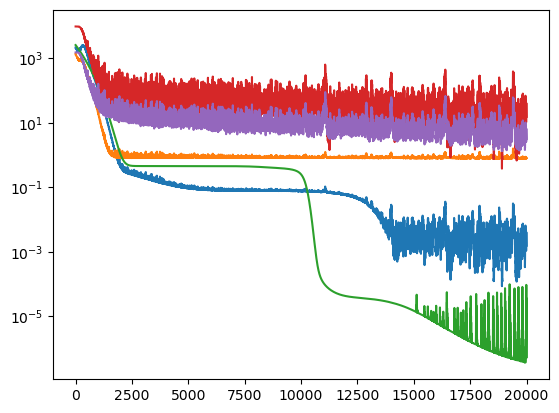

In [15]:
plt.plot(losses1)
plt.yscale('log')

In [22]:
epochs2=20000+1
params_est2 = np.zeros((epochs2, len(params_trainable1)))
def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = [item.numpy() for item in params_trainable1]

In [23]:
optimizer1.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [24]:
losses2 = tu.train(epochs=epochs2,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 20.898448190564523
l2_res_A: 0.00169279, l2_res_B: 0.77986425, l2_res_C: 0.00002003, l2_res_A_rhs: 16.81703568, l2_res_B_rhs: 3.29983544
D_A:0: 0.009614878334105015, D_B:0: 0.11719401180744171, b_A:0: 0.10017868131399155, b_B:0: 0.2926822602748871, b_C:0: 0.9995861649513245, V_A:0: 15.74991226196289, V_B:0: 29.990095138549805, V_C:0: 90.7698745727539, K_AA:0: 0.9602377414703369, K_AB:0: 1.7921327352523804, K_AC:0: 1.0279303789138794, K_BA:0: 0.5133904218673706, K_BC:0: 0.5051426291465759, K_CB:0: 90.0, K_CC:0: 0.98110431432724
Time taken: 0.23s

Start of epoch 200
at epoch 200, total loss: 1.8637037021600804
l2_res_A: 0.00005820, l2_res_B: 0.74062735, l2_res_C: 0.00000035, l2_res_A_rhs: 0.13395657, l2_res_B_rhs: 0.98906124
D_A:0: 0.009821301326155663, D_B:0: 0.12115658074617386, b_A:0: 0.09994428604841232, b_B:0: 0.2917633354663849, b_C:0: 0.9995439052581787, V_A:0: 15.75086498260498, V_B:0: 30.002582550048828, V_C:0: 90.76982116699219, K_AA:0:


Start of epoch 2800
at epoch 2800, total loss: 1.0470361682960458
l2_res_A: 0.00004840, l2_res_B: 0.59707224, l2_res_C: 0.00000028, l2_res_A_rhs: 0.05379226, l2_res_B_rhs: 0.39612299
D_A:0: 0.00981150008738041, D_B:0: 0.24323232471942902, b_A:0: 0.09997337311506271, b_B:0: 0.2670328915119171, b_C:0: 0.9995979070663452, V_A:0: 15.755701065063477, V_B:0: 30.23577880859375, V_C:0: 90.76982116699219, K_AA:0: 0.9599140286445618, K_AB:0: 1.5267843008041382, K_AC:0: 1.0244332551956177, K_BA:0: 0.514377236366272, K_BC:0: 0.5044699311256409, K_CB:0: 90.0, K_CC:0: 0.9805326461791992
Time taken: 54.55s

Start of epoch 3000
at epoch 3000, total loss: 0.9946418718442942
l2_res_A: 0.00004773, l2_res_B: 0.57887119, l2_res_C: 0.00000027, l2_res_A_rhs: 0.05006890, l2_res_B_rhs: 0.36565378
D_A:0: 0.009813422337174416, D_B:0: 0.2582715153694153, b_A:0: 0.09996628761291504, b_B:0: 0.26396065950393677, b_C:0: 0.9996052384376526, V_A:0: 15.756368637084961, V_B:0: 30.254972457885742, V_C:0: 90.7698211669921


Start of epoch 5600
at epoch 5600, total loss: 0.5881614433199189
l2_res_A: 0.00005115, l2_res_B: 0.36015946, l2_res_C: 0.00000013, l2_res_A_rhs: 0.09725367, l2_res_B_rhs: 0.13069704
D_A:0: 0.00980061199516058, D_B:0: 0.4729551374912262, b_A:0: 0.09997286647558212, b_B:0: 0.21942473948001862, b_C:0: 0.999745786190033, V_A:0: 15.768074989318848, V_B:0: 30.41306495666504, V_C:0: 90.7701644897461, K_AA:0: 0.9600629806518555, K_AB:0: 1.299201250076294, K_AC:0: 1.015255093574524, K_BA:0: 0.5143297910690308, K_BC:0: 0.5028243064880371, K_CB:0: 90.0, K_CC:0: 0.9788876175880432
Time taken: 55.33s

Start of epoch 5800
at epoch 5800, total loss: 0.5553431929245392
l2_res_A: 0.00005061, l2_res_B: 0.34690464, l2_res_C: 0.00000013, l2_res_A_rhs: 0.08495975, l2_res_B_rhs: 0.12342808
D_A:0: 0.009817318990826607, D_B:0: 0.4870474636554718, b_A:0: 0.09996456652879715, b_B:0: 0.21647965908050537, b_C:0: 0.9997556805610657, V_A:0: 15.769118309020996, V_B:0: 30.417325973510742, V_C:0: 90.77025604248047, 


Start of epoch 8400
at epoch 8400, total loss: 0.4267910925895251
l2_res_A: 0.00005556, l2_res_B: 0.21903785, l2_res_C: 0.00000024, l2_res_A_rhs: 0.13745715, l2_res_B_rhs: 0.07024030
D_A:0: 0.009811382740736008, D_B:0: 0.6390743851661682, b_A:0: 0.09997259825468063, b_B:0: 0.18403609097003937, b_C:0: 0.9998500347137451, V_A:0: 15.782451629638672, V_B:0: 30.433326721191406, V_C:0: 90.7708511352539, K_AA:0: 0.9602243304252625, K_AB:0: 1.201255440711975, K_AC:0: 1.0090794563293457, K_BA:0: 0.5142539143562317, K_BC:0: 0.501693844795227, K_CB:0: 90.0, K_CC:0: 0.9777424931526184
Time taken: 57.07s

Start of epoch 8600
at epoch 8600, total loss: 0.6037124985963089
l2_res_A: 0.00006903, l2_res_B: 0.21855465, l2_res_C: 0.00000007, l2_res_A_rhs: 0.29776675, l2_res_B_rhs: 0.08732200
D_A:0: 0.009809865616261959, D_B:0: 0.648651123046875, b_A:0: 0.09997273236513138, b_B:0: 0.18196819722652435, b_C:0: 0.9998526573181152, V_A:0: 15.783391952514648, V_B:0: 30.43285369873047, V_C:0: 90.7708740234375, 


Start of epoch 11200
at epoch 11200, total loss: 0.3444319801704694
l2_res_A: 0.00005621, l2_res_B: 0.14038731, l2_res_C: 0.00000005, l2_res_A_rhs: 0.15506309, l2_res_B_rhs: 0.04892532
D_A:0: 0.009811566211283207, D_B:0: 0.7525141835212708, b_A:0: 0.09996947646141052, b_B:0: 0.15933063626289368, b_C:0: 0.9999043941497803, V_A:0: 15.795848846435547, V_B:0: 30.417560577392578, V_C:0: 90.77115631103516, K_AA:0: 0.9603620767593384, K_AB:0: 1.1492098569869995, K_AC:0: 1.0056086778640747, K_BA:0: 0.5142005681991577, K_BC:0: 0.5010455846786499, K_CB:0: 90.0, K_CC:0: 0.9770909547805786
Time taken: 54.30s

Start of epoch 11400
at epoch 11400, total loss: 0.4542059337456976
l2_res_A: 0.00006433, l2_res_B: 0.14470801, l2_res_C: 0.00000006, l2_res_A_rhs: 0.24851096, l2_res_B_rhs: 0.06092258
D_A:0: 0.009810148738324642, D_B:0: 0.7588474750518799, b_A:0: 0.09997221827507019, b_B:0: 0.15795445442199707, b_C:0: 0.9999085068702698, V_A:0: 15.796820640563965, V_B:0: 30.416032791137695, V_C:0: 90.771163


Start of epoch 14000
at epoch 14000, total loss: 0.31733492070071634
l2_res_A: 0.00005992, l2_res_B: 0.09730894, l2_res_C: 0.00000005, l2_res_A_rhs: 0.17835669, l2_res_B_rhs: 0.04160932
D_A:0: 0.00981286820024252, D_B:0: 0.8337214589118958, b_A:0: 0.09997287392616272, b_B:0: 0.14138765633106232, b_C:0: 0.9999381303787231, V_A:0: 15.809821128845215, V_B:0: 30.391952514648438, V_C:0: 90.77127838134766, K_AA:0: 0.9605085849761963, K_AB:0: 1.1168805360794067, K_AC:0: 1.003583550453186, K_BA:0: 0.5141480565071106, K_BC:0: 0.500665545463562, K_CB:0: 90.0, K_CC:0: 0.9767045378684998
Time taken: 54.33s

Start of epoch 14200
at epoch 14200, total loss: 0.13927136315759014
l2_res_A: 0.00004396, l2_res_B: 0.08344870, l2_res_C: 0.00000004, l2_res_A_rhs: 0.03390826, l2_res_B_rhs: 0.02187040
D_A:0: 0.009810909628868103, D_B:0: 0.8384906649589539, b_A:0: 0.09997429698705673, b_B:0: 0.14030279219150543, b_C:0: 0.9999405741691589, V_A:0: 15.81088638305664, V_B:0: 30.389488220214844, V_C:0: 90.77128601


Start of epoch 16800
at epoch 16800, total loss: 1.0005515682075696
l2_res_A: 0.00012374, l2_res_B: 0.13932332, l2_res_C: 0.00000004, l2_res_A_rhs: 0.74072623, l2_res_B_rhs: 0.12037823
D_A:0: 0.00978854764252901, D_B:0: 0.8949640393257141, b_A:0: 0.10001429915428162, b_B:0: 0.12772101163864136, b_C:0: 0.9999590516090393, V_A:0: 15.824211120605469, V_B:0: 30.360368728637695, V_C:0: 90.7714614868164, K_AA:0: 0.9607637524604797, K_AB:0: 1.0945361852645874, K_AC:0: 1.0023813247680664, K_BA:0: 0.513977587223053, K_BC:0: 0.5004395246505737, K_CB:0: 90.0, K_CC:0: 0.9764726758003235
Time taken: 53.67s

Start of epoch 17000
at epoch 17000, total loss: 0.3795741360880669
l2_res_A: 0.00006513, l2_res_B: 0.07959387, l2_res_C: 0.00000005, l2_res_A_rhs: 0.25471103, l2_res_B_rhs: 0.04520405
D_A:0: 0.009825523942708969, D_B:0: 0.8990031480789185, b_A:0: 0.09998162090778351, b_B:0: 0.12673641741275787, b_C:0: 0.9999589920043945, V_A:0: 15.82534122467041, V_B:0: 30.35770606994629, V_C:0: 90.77147674560


Start of epoch 19600
at epoch 19600, total loss: 0.4777520362071641
l2_res_A: 0.00007496, l2_res_B: 0.07793076, l2_res_C: 0.00000004, l2_res_A_rhs: 0.34384412, l2_res_B_rhs: 0.05590215
D_A:0: 0.009817734360694885, D_B:0: 0.9351063370704651, b_A:0: 0.09998205304145813, b_B:0: 0.11863738298416138, b_C:0: 0.9999692440032959, V_A:0: 15.837823867797852, V_B:0: 30.330005645751953, V_C:0: 90.77147674560547, K_AA:0: 0.960808277130127, K_AB:0: 1.0807617902755737, K_AC:0: 1.0016686916351318, K_BA:0: 0.5140308737754822, K_BC:0: 0.5003035068511963, K_CB:0: 90.0, K_CC:0: 0.9763371348381042
Time taken: 54.38s

Start of epoch 19800
at epoch 19800, total loss: 0.7907072891331808
l2_res_A: 0.00009983, l2_res_B: 0.10866544, l2_res_C: 0.00000004, l2_res_A_rhs: 0.59112489, l2_res_B_rhs: 0.09081709
D_A:0: 0.009805136360228062, D_B:0: 0.937056839466095, b_A:0: 0.09997597336769104, b_B:0: 0.11819552630186081, b_C:0: 0.999971866607666, V_A:0: 15.838631629943848, V_B:0: 30.328203201293945, V_C:0: 90.771492004

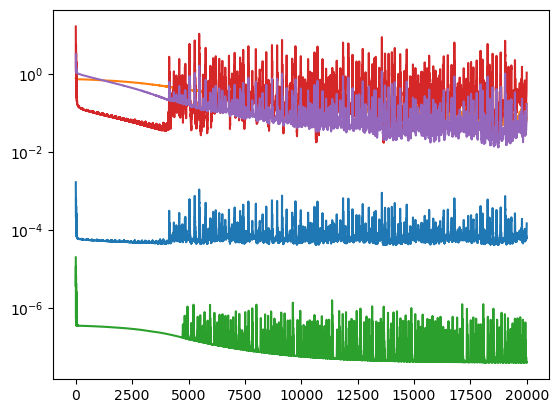

In [25]:
plt.plot(losses2)
plt.yscale('log')

In [ ]:
'b_A': 0.1, 'b_B': 0.1, 'b_C': 1.0 
'V_A': 20.0, 'V_B': 25.0, 'V_C': 100.0
'K_AA': 1.0, 
'K_AB': 1.0, 
'K_AC': 1.0,         
'K_BA': 0.5, 
'K_BC': 0.5, 
'K_CB': 100.0, 
'K_CC': 1.0

In [26]:
(D_A_val, D_B_val, b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = params_trainable1

In [27]:
(n_val, D_A_val, D_B_val,
 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = (params["n"], D_A_val, D_B_val,
                         b_A_val, b_B_val, b_C_val,
                         V_A_val, V_B_val, V_C_val,
                         params["mu_A"], params["mu_B"], params["mu_C"],
                         K_AA_val, K_AB_val, K_AC_val, 
                         K_BA_val, K_BC_val, 
                         K_CB_val, K_CC_val)

In [28]:
with open(f"./parameters_temp.npy", "wb") as f:
    np.save(f, (n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val))

In [29]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = D_A_val#params["D_A"]
D_B = D_B_val#params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [30]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der[1:-1,1:-1]-actual_A_der[1:-1,1:-1])**2))
    print(np.sum((B_der[1:-1,1:-1]-actual_B_der[1:-1,1:-1])**2))


    plot_n_im([to(A_xx)[1:-1,1:-1], c_xx[0,x_slice, y_slice , -1],
               to(A_yy)[1:-1,1:-1], c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx)[1:-1,1:-1], c_xx[1,x_slice, y_slice  , -1], 
               to(B_yy)[1:-1,1:-1], c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

0.00013266556
0.18539107


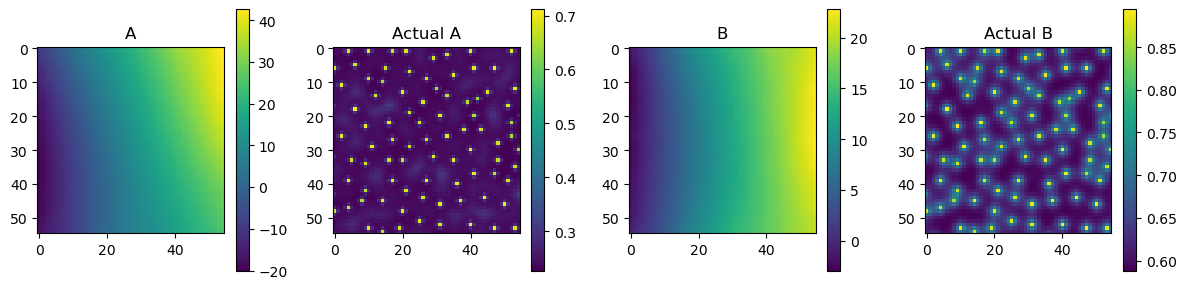

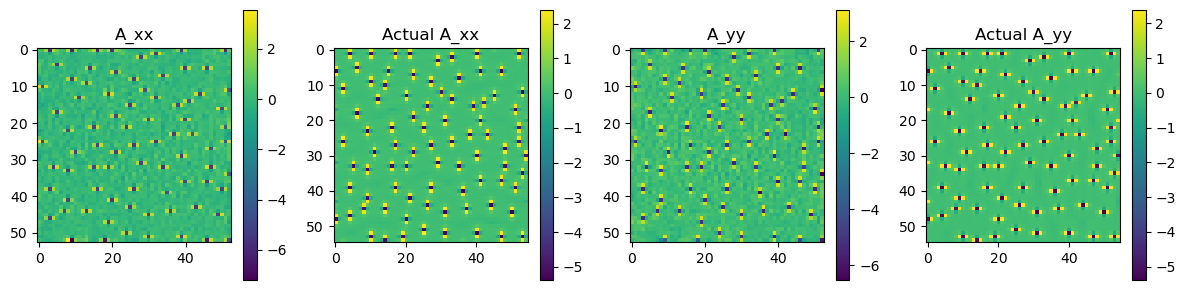

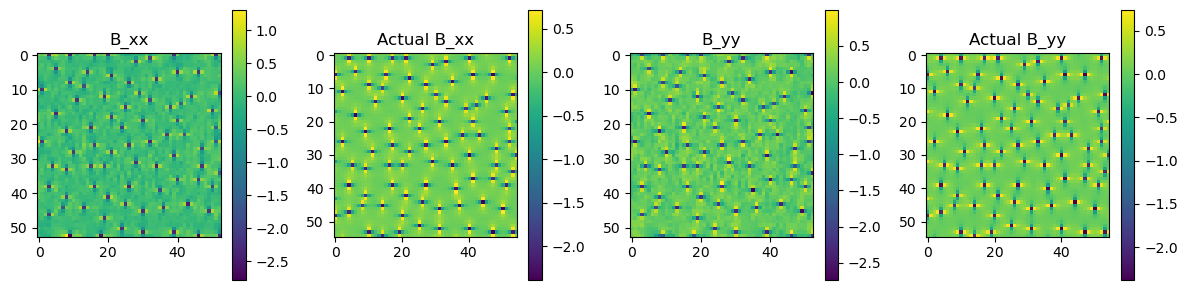

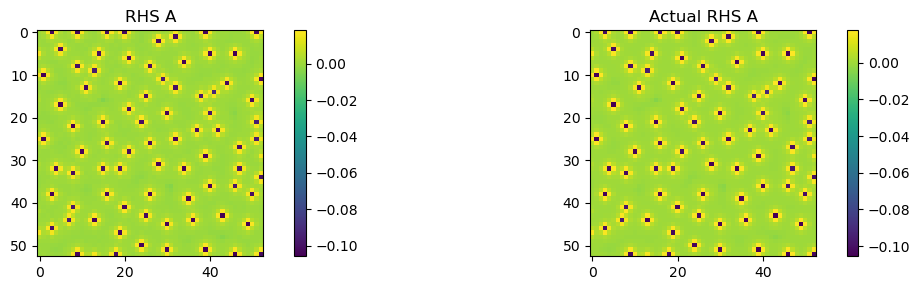

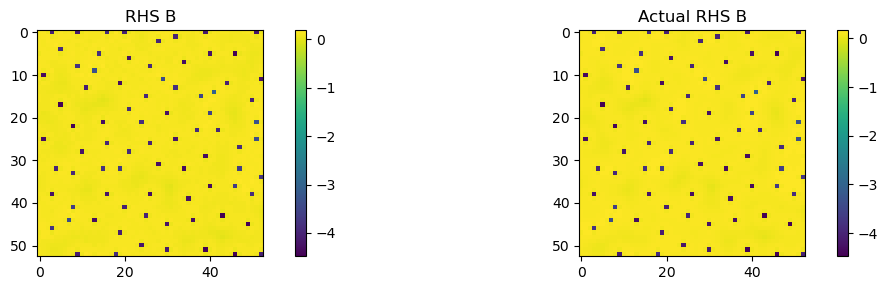

In [31]:
plot_state(pinn1)

In [48]:
def ratio(nom, dnom, n=2):
    return (nom / (dnom + 1e-20)) ** (n)
    
def act(x, km, n=2):
    return 1 / (1 + (km / (x + 1e-20)) ** (n))

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-20)) ** (n))

A = c[0,:, : , -1]
B = c[1,:, : , -1]
C = c[1,:, : , -1]

# f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
# f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
# f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C

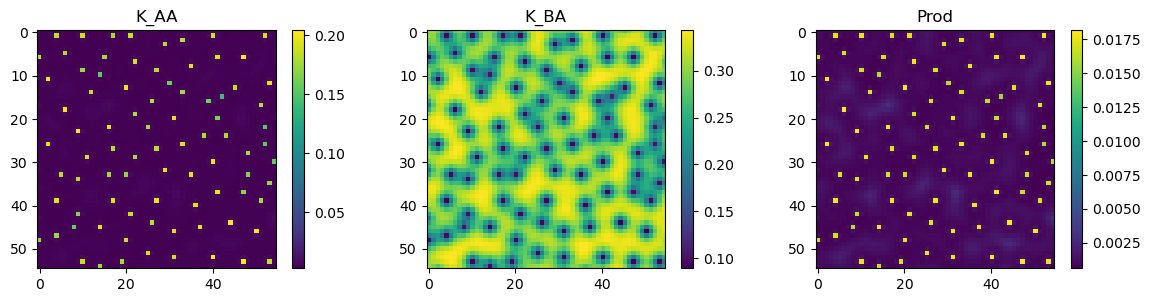

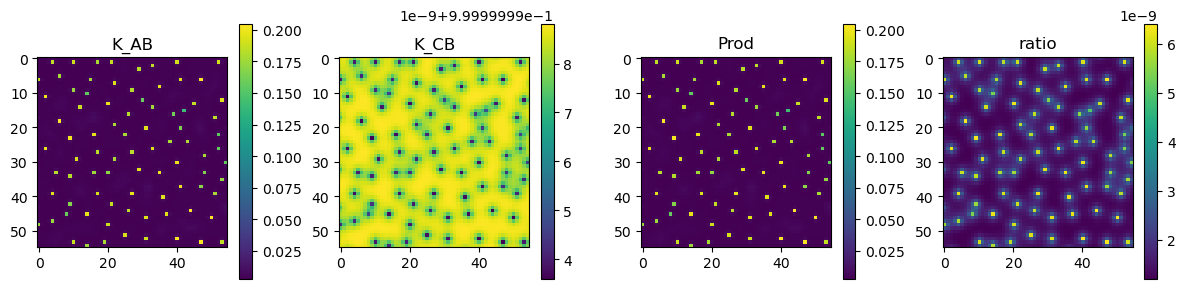

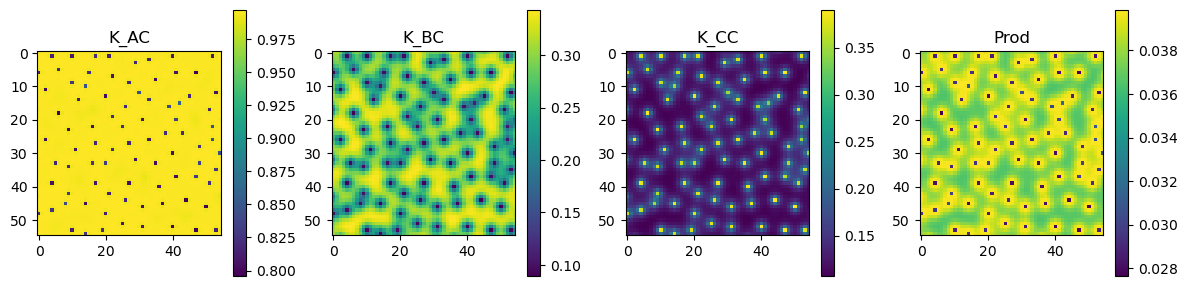

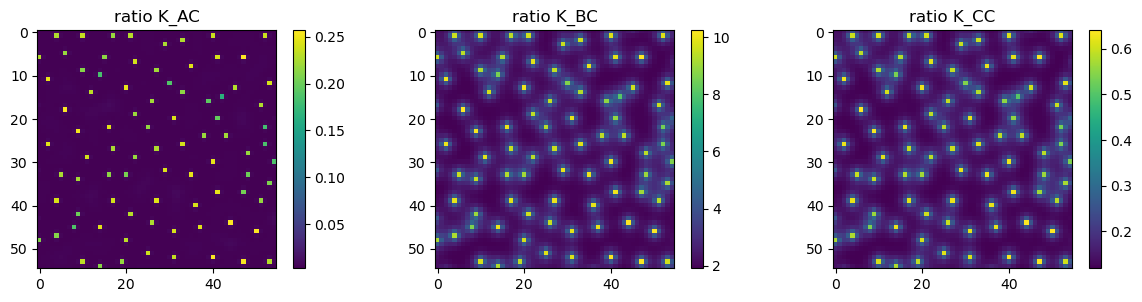

In [50]:
n = params["n"]
plot_n_im([act(A, params["K_AA"], n), inh(B, params["K_BA"], n), 
           act(A, params["K_AA"], n)*inh(B, params["K_BA"], n)],
          ["K_AA", "K_BA", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([act(A, params["K_AB"], n), inh(C, params["K_CB"], n), 
           act(A, params["K_AB"], n)*inh(C, params["K_CB"], n), ratio(C, params["K_CB"], n)],
          ["K_AB", "K_CB", "Prod", "ratio"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([inh(A, params["K_AC"], n), inh(B, params["K_BC"], n), act(C, params["K_CC"], n),
           inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n)],
          ["K_AC", "K_BC", "K_CC", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([ratio(A, params["K_AC"], n), ratio(B, params["K_BC"], n), ratio(C, params["K_CC"], n)],
          ["ratio K_AC", "ratio K_BC", "ratio K_CC"],
              figsize=(12, 3)); plt.tight_layout()